In [1]:
import sys
sys.path.insert(0, '/Users/user/Documents/ecg_research/')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.externals import joblib as jl
from py_files import ecg_util
%matplotlib inline


In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import wfdb as wf
import scipy.signal as ss
from sklearn.externals import joblib as jl
from biosppy.signals import ecg as ecgsig
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import peakutils as pu

In [3]:
path_arr = '/Users/user/physionet.org/physiobank/database/ltafdb/'

In [12]:
patient = '01'
records = 'RECORDS'
records_arr = np.loadtxt(path_arr + records, 'str')
records_arr = np.array([i[2:4] for i in records_arr])

In [13]:
records_arr

array(['00', '01', '03', '05', '06', '07', '08', '10', '10', '10', '10',
       '10', '10', '10', '11', '11', '11', '11', '11', '11', '11', '11',
       '11', '11', '11', '12', '12', '12', '12', '13', '15', '16', '17',
       '18', '19', '20', '20', '20', '20', '20', '20', '20', '20', '20',
       '20', '21', '22', '23', '24', '25', '26', '28', '30', '32', '33',
       '34', '35', '37', '38', '39', '42', '43', '44', '45', '47', '48',
       '49', '51', '53', '54', '55', '56', '58', '60', '62', '64', '65',
       '68', '69', '70', '71', '72', '74', '75'], 
      dtype='<U2')

In [14]:
records_arr.shape

(84,)

In [16]:
f = 128 #Hz
window = int(0.4 * f) #second half-window

# Curating/Separating AF from Non-AF

In [18]:
af_list, n_list = [], []
patient_dict = {}
for i in records_arr:
    pat = i
    sig, fields = wf.rdsamp(path_arr + i)
    ann_temp = wf.rdann(path_arr + i, 'qrs')
    arr_ann = np.array(ann_temp[1])
    arr_idx = np.array(ann_temp[0])
    ecg = sig[:,0]
    ecg_idx = np.linspace(0, ecg.shape[0], ecg.shape[0])
    if 'T' in arr_ann:
        arr_ann[np.where(arr_ann == 'N')] = 0
        arr_ann[np.where(arr_ann == 'T')] = 1
        T_idx = arr_idx[np.where(arr_ann == '1')][0]
#         AF_idx = np.where(ecg_idx < T_idx)
#         N_idx = np.where(ecg_idx > T_idx)
        af_peak_idx = arr_idx[np.where(arr_idx < T_idx)]
        n_peak_idx = arr_idx[np.where(arr_idx > T_idx)]
        af = np.array([ecg[i - window: i + window] for i in af_peak_idx[100:-100]])
        n = np.array([ecg[i - window: i + window] for i in n_peak_idx[100:-100]])
        num_af, _ = af.shape
        num_n, _ = n.shape
        num_samples = 10000
        if num_af > num_samples and num_n > num_samples:
        
            af_list.append(af[:num_samples])
            n_list.append(n[:num_samples])
        else:
            af_list.append(af)
            n_list.append(n)
            patient_dict[pat] = ecg
            print (pat)
            
        


06
38
42
72


In [19]:
af_arr = np.concatenate(af_list)
n_arr = np.concatenate(n_list)

In [20]:
# ltafdb_dict = {'AF':af_arr, 'N':n_arr}
# jl.dump(ltafdb_dict, '../ecg_research/Databases/AFIB_database.pickle')

In [21]:
print (af_arr.shape, n_arr.shape)

(278399, 102) (686224, 102)


In [22]:
af_label = np.array(['1']* af_arr.shape[0])
n_label = np.array(['0']* n_arr.shape[0])

In [23]:
X_ = np.concatenate([af_arr, n_arr])
y_ = np.concatenate([af_label, n_label])

In [24]:
pca = PCA(n_components=20)
X_new_ = pca.fit_transform(X_)

In [26]:
X_new_.shape

(964623, 20)

In [27]:
# X_c = StandardScaler().fit_transform(X_new)
X_train, X_test, y_train, y_test = train_test_split(X_new_, y_, test_size=.4, random_state=42)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [28]:
best_classifier = MLPClassifier((100, 100, 100))
best_classifier.fit(X_train, y_train)
score = best_classifier.score(X_test, y_test)

# Test on Specific Patient

In [29]:
afib_patient_dict = jl.load('/Users/user/Documents/ecg_research/Databases/AFIB_patients.pickle')

In [46]:
afib_patient_test = afib_patient_dict[b'06'][60000:120000]

In [47]:
f = 120
ecg = afib_patient_test
window = int(f * 0.4) #800ms beat
ecg_new = ecg_util.baseline_correct(ecg, f)
rpeaks = np.array(ecgsig.hamilton_segmenter(ecg_new, f)['rpeaks'])[2:-2] #detect rpeaks from ecg
beats = np.array([ecg_new[i - window: i + window] for i in rpeaks])
pca = PCA(n_components=20)
beats_new = pca.fit_transform(beats)

In [48]:
pred_pat = best_classifier.predict(beats_new)

### Predicted as Normal Beat

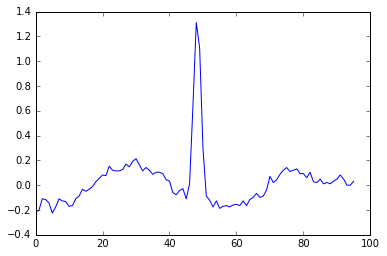

In [49]:
plt.plot(beats[np.where(pred_pat == '0')[0][0]])

### Predicted as Afib Beat

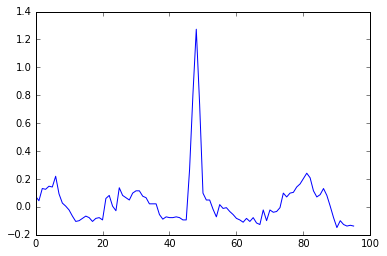

In [50]:
plt.plot(beats[np.where(pred_pat == '1')[0][0]])